# 0 - Setup

In [2]:
!pip install --upgrade torchvision
!pip install --upgrade torch
import torch
import torchvision
print(f"torch version:{torch.__version__}")
print(f"torchvision version:{torchvision.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 24.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 61.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 49.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 22.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 11.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━

In [3]:
import matplotlib.pyplot as plt
from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

In [4]:
# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 43.53 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


## Ensuring proper CUDA details

In [5]:
!pip install --upgrade torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 13.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.1.2
    Uninstalling torchaudio-2.1.2:
      Successfully uninstalled torchaudio-2.1.2


## Device Agnostic Code

In [6]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1 - Getting Data
The dataset we're going to use for deploying a food101_mini_classification model is...

Pizza, steak, sushi 20% dataset (pizza, steak, sushi classes from Food101, random 20% of samples)

In [7]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path=download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")
data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [8]:
# setup training and test paths
train_dir=data_20_percent_path/"train"
test_dir=data_20_percent_path/"test"
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

# 2 - Creating an EffNetB2 feature extractor
Feautre extractor = a term for a transfer learning model that has its base layers frozen and output layers (or head layers) customized to a certain problem.

EffNetB2 pretrained model in PyTorch - https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.EfficientNet_B2_Weights

In [9]:
import torchvision

# 1. setup pretrained EfficeintB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT #DEFAULT means best

# 2. Get EffNetB2 transforms
effnetb2_transform=effnetb2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# 4. Freeze the base layers in the model (this will stop all layers from training)
for param in effnetb2.parameters():
  param.requires_grad=False



Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 126MB/s] 


In [10]:
from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [11]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [12]:
set_seeds()
effnetb2.classifier=nn.Sequential(nn.Dropout(p=0.3,inplace=True),
                                  nn.Linear(in_features=1408,out_features=3))

In [13]:

from torchinfo import summary

# Print EffNetB2 model summary (uncomment for full output)
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 2.1 - Creating a function to make an EffNetB2 feature extractor

In [14]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transform=weights.transforms()
  model=torchvision.models.efficientnet_b2(weights=weights)



  for param in model.parameters():
    param.requires_grad=False
  torch.manual_seed(seed)
  model.classifier=nn.Sequential(nn.Dropout(p=0.3,inplace=True),
                                 nn.Linear(in_features=1408,out_features=num_classes))
  return model,transform


In [15]:
effnetb2,effnetb2_transforms=create_effnetb2_model(num_classes=3,
                                                   seed=42)

In [16]:
from torchinfo import summary
summary(model=effnetb2,
        input_size=(1,3,288,288),
        col_names=["input_size","output_size","num_params","trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 288, 288]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 288, 288]     [1, 1408, 9, 9]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 288, 288]     [1, 32, 144, 144]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 288, 288]     [1, 32, 144, 144]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 144, 144]    [1, 32, 144, 144]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 144, 144]    [1, 32, 144, 144]    --                   --
│    └─Sequential (1)                                        [1, 32, 144, 144]    [1, 1

## 2.2 - Creating DataLoaders for EffNetB2

In [17]:
from going_modular.going_modular import data_setup
train_dataloader_effnetb2,test_dataloader_effnetb2,class_names=data_setup.create_dataloaders(train_dir=train_dir,
                                                                                    test_dir=test_dir,
                                                                                    transform=effnetb2_transforms,
                                                                                    batch_size=32)


In [18]:
len(train_dataloader_effnetb2),len(test_dataloader_effnetb2),class_names

(15, 5, ['pizza', 'steak', 'sushi'])

## 2.3 - Training EffNetB2 feature extractor

### 2.3.0 Creating Essential methods

In [19]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        with torch.amp.autocast(device_type='cuda'):
            y_pred = model(X)
            # 2. Calculate  and accumulate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [20]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            with torch.amp.autocast(device_type='cuda'):
                test_pred_logits = model(X)

                # 2. Calculate and accumulate loss
                loss = loss_fn(test_pred_logits, y)
                test_loss += loss.item()

                # Calculate and accumulate accuracy
                test_pred_labels = test_pred_logits.argmax(dim=1)
                test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


In [21]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [22]:
import torch
from torch.nn import DataParallel
# remove comment from line below if using single GPU
#from going_modular.going_modular import engine 

# Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=1e-3)  # 0.001

# Set seeds for reproducibility -- # remove comment from line below if using single GPU
# set_seeds()

# Wrap the model with DataParallel
effnetb2 = DataParallel(effnetb2)

# Ensure the model is on the correct device
effnetb2 = effnetb2.to(device)

In [23]:
# Train the model

# remove comment from line below if using single GPU
# effnetb2_results = engine.train(
#     model=effnetb2,
#     train_dataloader=train_dataloader_effnetb2,
#     test_dataloader=test_dataloader_effnetb2,
#     epochs=10,
#     optimizer=optimizer,
#     loss_fn=loss_fn,
#     device=device
# )

# for multiple GPU
effnetb2_results = train(
    model=effnetb2,
    train_dataloader=train_dataloader_effnetb2,
    test_dataloader=test_dataloader_effnetb2,
    epochs=10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epoch: 1 | train_loss: 1.0191 | train_acc: 0.5458 | test_loss: 0.7581 | test_acc: 0.8886
Epoch: 2 | train_loss: 0.7662 | train_acc: 0.7438 | test_loss: 0.6248 | test_acc: 0.9227
Epoch: 3 | train_loss: 0.6186 | train_acc: 0.8688 | test_loss: 0.5296 | test_acc: 0.9131
Epoch: 4 | train_loss: 0.5441 | train_acc: 0.8396 | test_loss: 0.4580 | test_acc: 0.9347
Epoch: 5 | train_loss: 0.4742 | train_acc: 0.9000 | test_loss: 0.4021 | test_acc: 0.9409
Epoch: 6 | train_loss: 0.4253 | train_acc: 0.8792 | test_loss: 0.3768 | test_acc: 0.9563
Epoch: 7 | train_loss: 0.4532 | train_acc: 0.8292 | test_loss: 0.3440 | test_acc: 0.9659
Epoch: 8 | train_loss: 0.3911 | train_acc: 0.9000 | test_loss: 0.3209 | test_acc: 0.9597
Epoch: 9 | train_loss: 0.4045 | train_acc: 0.8729 | test_loss: 0.2961 | test_acc: 0.9722
Epoch: 10 | train_loss: 0.4017 | train_acc: 0.8458 | test_loss: 0.2935 | test_acc: 0.9500


## 2.4 - Inspecting EffNetB2 loss curves

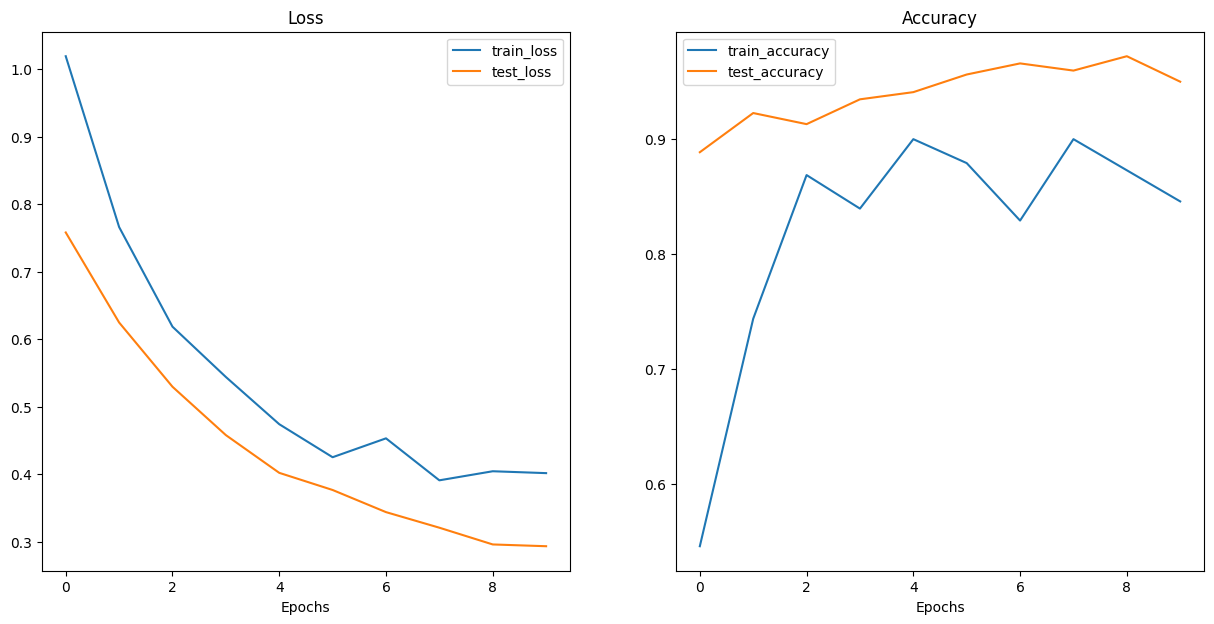

In [24]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

## 2.5 - gg EffNetB2 feature extractor

In [27]:
import os
from going_modular.going_modular import utils

# # Save the model - Uncomment if not using DataParallel prefix
# utils.save_model(model=effnetb2,
#                  target_dir="models",
#                  model_name="effnetb2_feature_extractor_food101_mini.pth")

# Remove the "module." prefix before saving -- to be used only with Multiple GPU 
# Ensure the 'models' directory exists
os.makedirs("models", exist_ok=True)
state_dict = effnetb2.module.state_dict()  # `module` is your original model inside DataParallel
torch.save(state_dict, "models/effnetb2_feature_extractor_food101_mini.pth")


## 2.6 - Inspecting the size of our EffNetB2 feature extractor

In [ ]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path("models/effnetb2_feature_extractor_food101_mini.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)} MB")

# 3 - Deployed Gradio app structure
Let's start to put all of our app files into a single directory:
```
Colab -> folder with all Gradio files -> upload app files to Hugging Face Spaces -> deploy
```
By the end our file structure will look like this:

```
demos/
└── food101_mini_classification/
    ├── effnetb2_feature_extractor_food101_mini.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```


In [ ]:
import shutil
from pathlib import Path

# Create food101_mini_classification demo path
food101_mini_classification_demo_path=Path("demos/food101_mini_classification/")

# Remove files that might exist and create a new directory
if food101_mini_classification_demo_path.exists():
  shutil.rmtree(food101_mini_classification_demo_path)

# Create the new directory
food101_mini_classification_demo_path.mkdir(parents=True,
                                  exist_ok=True)

!ls demos/food101_mini_classification/


## 3.1 - Creating a folder of example images to use with our food101_mini_classification demo

What we want:

*    3 images in an examples/ directory
*    Images should be from the test set


In [ ]:
import shutil
from pathlib import Path

# Create an examples directory
food101_mini_classification_examples_path = food101_mini_classification_demo_path/"examples"
food101_mini_classification_examples_path.mkdir(parents=True,exist_ok=True)

# Collect three random test dataset image paths
food101_mini_classification_examples=[Path('data/pizza_steak_sushi_20_percent/test/pizza/482858.jpg'),
                          Path('data/pizza_steak_sushi_20_percent/test/steak/1523026.jpg'),
                          Path('data/pizza_steak_sushi_20_percent/test/sushi/46797.jpg')]

# copy the three images to the example directory

for example in food101_mini_classification_examples:
  destination=food101_mini_classification_examples_path/example.name # .name returns the file name
  print(f"[INFO] Copying {example} to {destination}")
  shutil.copy2(src=example,
               dst=destination)



Let's now verify that we can get a list of lists from our `examples/` directory.

In [ ]:
import os
# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(food101_mini_classification_examples_path)]
example_list

## 3.2 - Moving our trained EffNetB2 model to our food101_mini_classification demo directory

In [ ]:
import shutil

# Create a source path for our target model
effnetb2_food101_mini_classification_model_path = "models/effnetb2_feature_extractor_food101_mini.pth"

# Create a destination path for our target model
effnetb2_food101_mini_classification_model_destination = food101_mini_classification_demo_path / effnetb2_food101_mini_classification_model_path.split("/")[1]

# Try to move the model file
try:
  print(f"[INFO] Attempting to move {effnetb2_food101_mini_classification_model_path} to {effnetb2_food101_mini_classification_model_destination}")

  # Move the movel
  shutil.move(src=effnetb2_food101_mini_classification_model_path,
              dst=effnetb2_food101_mini_classification_model_destination)

  print(f"[INFO] Model move complete.")
# If the model has already been moved, check if it exists
except:
  print(f"[INFO] No model found at {effnetb2_food101_mini_classification_model_path}, perhaps its already been moved?")
  print(f"[INFO] Model exists at {effnetb2_food101_mini_classification_model_destination}: {effnetb2_food101_mini_classification_model_destination.exists()}")


## 3.3 - Turning off EffNetB2 model into a Python script (model.py)

We have a saved `.pth` model `state_dict` and want to load it into a model instance.

Let's move our `create_effnetb2_model()` function to a script so we can reuse it.

In [ ]:
%%writefile demos/food101_mini_classification/model.py
import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  # 1, 2, 3 Create EffNetB2 pretrained weights, transforms and model
  weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms=weights.transforms()
  model=torchvision.models.efficientnet_b2(weights=weights)

  for param in model.parameters():
    param.requires_grad=False
    model.classifier=nn.Sequential(
        nn.Dropout(p=0.3,inplace=True),
        nn.Linear(in_features=1408,out_features=num_classes)
    )
  return model,transforms



## 3.4 - Turning our Food101 Mini Gradio app into a Python script (`app.py`)

In [ ]:
%%writefile demos/food101_mini_classification/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple,Dict

# Setup class names
class_names=["pizza","steak","sushi"]
### 2. Model and transforms perparation ###
effnetb2,effnetb2_transforms=create_effnetb2_model(num_classes=len(class_names))

# Load save weights _ UNcomment below if not using multiple Gpu
# effnetb2.load_state_dict(
#     torch.load(
#         f="effnetb2_feature_extractor_food101_mini.pth",
#         map_location=torch.device("cpu") # load the model to the CPU
#     )
# )
# Load the state_dict (no DataParallel prefix)
effnetb2.load_state_dict(torch.load("models/effnetb2_feature_extractor_food101_mini.pth", map_location=torch.device("cpu")))

# Wrap with DataParallel if needed
effnetb2 = DataParallel(effnetb2).to(device)

### 3. Predict function ###
def predict(img)->Tuple[Dict,float]:
  # start a timer
  start_time = timer()

  # Transform the input image for use with EffNetB2
  img=effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

  # Put model into eval mode, make prediction
  effnetb2.eval()
  with torch.inference_mode():
    # Pass transformed image through the model and turn the prediction logits into probaiblities
    pred_probs=torch.softmax(effnetb2(img),dim=1)

  # Create a prediction label and prediction probability dictionary
  pred_labels_and_probs = {}

  # pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
  # comment loop below to un-comment line above
  for i,class_name in enumerate(class_names):
    pred_labels_and_probs[class_name]=pred_probs[0][i]

  # Calculate pred time
  end_time=timer()
  pred_time=round(end_time-start_time,4)

  # Return pred dict and pred time
  return pred_labels_and_probs,pred_time

### 4. Gradio app ###

# Create title, description and article

title="Food101 Big Classification"
description = "An [EfficientNetB2 feature extractor](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2) computer vision model to classify images as pizza, steak or sushi."
article = "Created at [Food101 Mini Classification](https://github.com/MRameezU/Food-101-Mini-Classification.git)."

# Create example list
# Create example list
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # maps inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                             gr.Number(label="Prediction time (s)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

## 3.5 - Creating a requirements file for Food101 Mini (`requirements.txt`)

The requirements file will tell our Hugging Face Space what software dependencies our app requires.

The three main ones are:

*    `torch`
*    `torchvision`
*    `gradio`

In [ ]:
%%writefile demos/food101_mini_classification/requirements.txt

torch==1.12.0
torchvision==0.13.0
gradio==4.38.1
numpy<2

## Downloading our Food101 Mini app

In [ ]:
!ls demos/food101_mini_classification/examples

In [ ]:
# Change into the food101_mini directory and then zip it from the inside
!cd demos/food101_mini_classification && zip -r ../food101_mini_classification.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"